In [173]:
#modified from
#https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm
#https://www.kaggle.com/nicapotato/miao-boosting-aggregate-features

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier
import gc

pd.set_option('display.max_columns',1000)

gc.enable()

def PivotGroupBy(df, groupby_id, target_id, feature_name='', cutoff=0.1):
    print('Pivot and Group on: {0}, {1}'.format(target_id, df.shape))
    cnt_name = 'cnt_{0}'.format(target_id)
    tmp = df.groupby([groupby_id])[target_id].value_counts(normalize=True)
    if len(tmp) > 2:
        tmp = tmp.loc[tmp >= cutoff].rename(cnt_name).reset_index()
    else:
        tmp = tmp.iloc[:1].rename(cnt_name).reset_index()
    tmp = tmp.pivot(index=groupby_id, columns=target_id, values=cnt_name)
    tmp.rename(columns={f:'{0}_r={1}'.format(feature_name, f) for f in tmp.columns}, inplace=True)
    return tmp

def LabelMeanEnc(X, y, test_X, encode_feats):    
    for f_ in encode_feats:
        df = pd.concat([y, X[f_]], axis=1).groupby(f_).agg(['mean'])
        df = df.squeeze().rename('mean_{}'.format(f_))
        print(f_, df.shape)
        X = X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        test_X = test_X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        del df; gc.collect()
        
    return X, test_X


def LabelStdEnc(X, y, test_X, encode_feats):    
    for f_ in encode_feats:
        df = pd.concat([y, X[f_]], axis=1).groupby(f_).agg(['std'])
        df = df.squeeze().rename('std_{}'.format(f_))
        print(f_, df.shape)
        X = X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        test_X = test_X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        del df; gc.collect()
        
    return X, test_X

def LabelQuantileEnc(X, y, test_X, encode_feats):    
    for f_ in encode_feats:
        df = pd.concat([y, X[f_]], axis=1).groupby(f_).agg(['quantile'])
        df = df.squeeze().rename('quantile_{}'.format(f_))
        print(f_, df.shape)
        X = X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        test_X = test_X.merge(df.to_frame(), how='left', left_on=f_, right_index=True)
        del df; gc.collect()
        
    return X, test_X

def CatMeanEnc(df, index_name, groupby_ids):

    cat_features = [f_ for f_ in df.columns if df[f_].dtype == 'object']
    not_cat_features = [f for f in df.columns if f not in cat_features]
    
    #pivot on categorcals
    list_df_pivots = [PivotGroupBy(df, index_name, f_, feature_name=f_) for f_ in cat_features]
    df_pivots = pd.concat(list_df_pivots, axis=1)
    del list_df_pivots; gc.collect()
    df_pivots['na_cnt_{0}'.format(index_name)] = pd.isnull(df_pivots).apply(lambda x: sum(x.astype(int)), axis=1)
    print(df_pivots.head())
    
    #miao on
    ###["sum", "mean", "max", "min", "std"] = bazowe
    ###["sum", "mean", "max", "min", "std", "quantile"] - aktualnie najlepsze .793
    ###["sum", "mean", "max", "min", "std", "median"] - do przetestowania
    
    df_miao = df[not_cat_features].groupby(groupby_ids).agg({k:["sum", "mean", "max", "min", "std", "median", "quantile"] for k in not_cat_features})
    df_miao.columns = pd.Index(["{0}_{1}".format(e[0], e[1]) for e in df_miao.columns.tolist()])
    df_ret = df_miao.join(df_pivots, how='left')
    print(df_miao.head())

    del df_miao, df_pivots; gc.collect()
    
    print(df_ret.describe())
    df_ret['cnt_{:}'.format(index_name)] = df[[groupby_ids, index_name]].groupby(groupby_ids).count()[index_name]
    if index_name in df_ret.columns:
        del df_ret[index_name]
        print('del index {0}'.format(index_name))
    return df_ret
    
def JoinMeanEnc(main_df, join_dfs=[]):
    for df in join_dfs:
        print(main_df.shape, df.shape)
        f_join = [f_ for f_ in df.columns if f_ not in main_df.columns]
        main_df = main_df.join(df[f_join], how='left')
        print('concat {0} to {1}'.format(df.shape, main_df.shape))
    return main_df

def OOFPreds(X, y, test_X, params, n_splits=5, random_state=42, clf='lgb'):
    
    feature_importance = []
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds, sub_preds = np.zeros(X.shape[0]), np.zeros(test_X.shape[0])
    print(X.shape, test_X.shape)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data, y)):
        trn_x, trn_y = X.iloc[trn_idx], y.iloc[trn_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
        trn_init_score = pd.Series([0.9] * len(trn_x), index=trn_x.index) 
        val_init_score = pd.Series([0.9] * len(val_x), index=val_x.index)
        if clf == 'lgb':
            gbm = LGBMClassifier(**params)    
            gbm.fit(trn_x, trn_y, init_score=trn_init_score,
                    eval_set=[(trn_x, trn_y), (val_x, val_y)], 
                    eval_init_score=[trn_init_score, val_init_score],
                    eval_metric='auc', verbose=150, early_stopping_rounds=150)
            pred_val  = gbm.predict_proba(val_x, num_iteration=gbm.best_iteration_)[:, 1]
            pred_test = gbm.predict_proba(test_X, num_iteration=gbm.best_iteration_)[:, 1]

        oof_preds[val_idx] = pred_val
        sub_preds += pred_test / folds.n_splits
        print('Fold {:02d} AUC: {:.6f}'.format(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del trn_x, trn_y, val_x, val_y; gc.collect()

        feature_importance.append(pd.DataFrame({
                'importance': gbm.feature_importances_,
                'fold': [n_fold + 1] * X.shape[1],
                'feature': X.columns.tolist()},).set_index('feature'))
        
    oof_preds = pd.Series(oof_preds.flatten(), index=X.index).rename('TARGET')
    sub_preds = pd.Series(sub_preds.flatten(), index=test_X.index).rename('TARGET')
    return oof_preds, sub_preds, feature_importance



In [290]:
data = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
subm = pd.read_csv('input/sample_submission.csv')

In [291]:
data.shape, test.shape

((79853, 13), (34224, 12))

In [293]:
test

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600
5,64797,0.112,16065,245130,0.0,0.0,0.0,98.88,7,B,Rural,11700
6,67412,0.325,17167,388050,6.0,0.0,0.0,99.00,27,C,Urban,3300
7,44241,0.362,20085,99880,3.0,0.0,0.0,98.40,14,A,Urban,5400
8,5069,0.115,23008,360040,0.0,0.0,0.0,99.88,6,D,Rural,13800
9,16615,0.021,21906,510040,0.0,0.0,0.0,99.89,11,B,Urban,28500


In [294]:
y = data[['id','renewal']]
del data['renewal']
y

,id,renewal
0,110936,1
1,41492,1
2,31300,0
3,19415,1
4,99379,1
5,59951,1
6,54031,1
7,94290,0
8,93730,1
9,84844,0


In [295]:
categorical_feats = [f for f in data.columns if data[f].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_feats)
test = pd.get_dummies(test, columns=categorical_feats)

In [296]:
A = [f for f in data.columns]
features = A
len(A)

17

In [301]:
features

['id',
 'perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'premium',
 'sourcing_channel_A',
 'sourcing_channel_B',
 'sourcing_channel_C',
 'sourcing_channel_D',
 'sourcing_channel_E',
 'residence_area_type_Rural',
 'residence_area_type_Urban']

In [297]:
data = data.set_index('id')
test = test.set_index('id')
y = y.set_index('id')

In [298]:
y = y['renewal']
y

id
110936    1
41492     1
31300     0
19415     1
99379     1
59951     1
54031     1
94290     0
93730     1
84844     0
87400     1
51808     1
104167    1
52420     1
42421     1
91820     1
64685     1
60263     1
68260     1
4043      0
100259    1
90347     1
92720     1
72071     1
19900     1
111305    1
27507     1
53784     1
102354    1
108046    1
         ..
109885    0
8128      1
51459     1
90947     1
68247     1
99803     1
61778     0
3611      1
19961     1
72079     1
66984     1
64094     1
59873     1
64935     1
62584     1
105366    1
50858     1
23546     1
43884     1
95947     1
84628     1
11262     1
25366     1
104705    1
91081     1
48057     1
59012     1
77050     1
67225     1
71531     0
Name: renewal, Length: 79853, dtype: int64

In [26]:
test.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
id,,,,,,,,,,,
649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,1,1,3300
81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,1,0,11700
70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,2,0,11700
53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,2,1,5400
15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,1,1,9600


In [306]:
data['new_-2'] = data['Income']/12 + data['premium']/12
data['new_-1'] = (data['Income']/12)/(data['age_in_days']/365.25)
data['new_0'] = data['new_1'] = data['Income']/12 / data['premium']/12
data['new_1'] = data['Income']/12 - data['premium']/12
data['new_2'] = data['age_in_days']/365.25
data['new_3'] = data['new_1']*data['residence_area_type_Rural']
data['new_31'] = data['new_1']*data['residence_area_type_Urban']

data['new_4'] = data['no_of_premiums_paid']*data['premium']
data['new_5'] = data['Count_3-6_months_late']*data['premium']
data['new_6'] = data['Count_6-12_months_late']*data['premium']
data['new_7'] = data['Count_more_than_12_months_late']*data['premium']
data['new_8'] = (data['Income']/12)*data['residence_area_type_Rural']
data['new_81'] = (data['Income']/12)*data['residence_area_type_Urban']
data['new_9'] = (data['Income']/12)*data['sourcing_channel_A']
data['new_9b'] = (data['Income']/12)*data['sourcing_channel_B']
data['new_9c'] = (data['Income']/12)*data['sourcing_channel_C']
data['new_9d'] = (data['Income']/12)*data['sourcing_channel_D']
data['new_9e'] = (data['Income']/12)*data['sourcing_channel_E']

data['new_10']= data['premium']*data['perc_premium_paid_by_cash_credit']


test['new_-2'] = test['Income']/12 + test['premium']/12
test['new_-1'] = (test['Income']/12)/(test['age_in_days']/365.25)
test['new_0'] = test['Income']/12 / test['premium']/12
test['new_1'] = test['Income']/12 - test['premium']/12
test['new_2'] = test['age_in_days']/365.25
test['new_3'] = test['new_1']*test['residence_area_type_Rural']
test['new_31'] = test['new_1']*test['residence_area_type_Urban']

test['new_4'] = test['no_of_premiums_paid']*test['premium']
test['new_5'] = test['Count_3-6_months_late']*test['premium']
test['new_6'] = test['Count_6-12_months_late']*test['premium']
test['new_7'] = test['Count_more_than_12_months_late']*test['premium']
test['new_8'] = (test['Income']/12)*test['residence_area_type_Rural']
test['new_81'] = (test['Income']/12)*test['residence_area_type_Urban']
test['new_9'] = (test['Income']/12)*test['sourcing_channel_A']
test['new_9b'] = (test['Income']/12)*test['sourcing_channel_B']
test['new_9c'] = (test['Income']/12)*test['sourcing_channel_C']
test['new_9d'] = (test['Income']/12)*test['sourcing_channel_D']
test['new_9e'] = (test['Income']/12)*test['sourcing_channel_E']
test['new_10']= test['premium']*test['perc_premium_paid_by_cash_credit']

In [307]:
A = [f for f in data.columns]
A

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'premium',
 'sourcing_channel_A',
 'sourcing_channel_B',
 'sourcing_channel_C',
 'sourcing_channel_D',
 'sourcing_channel_E',
 'residence_area_type_Rural',
 'residence_area_type_Urban',
 'new_-2',
 'new_-1',
 'new_0',
 'new_1',
 'new_2',
 'new_3',
 'new_31',
 'new_4',
 'new_5',
 'new_6',
 'new_7',
 'new_8',
 'new_81',
 'new_9',
 'new_9b',
 'new_9c',
 'new_9d',
 'new_9e',
 'new_10']

In [308]:
ficzers_data = data.mean()
ficzers_data = pd.DataFrame(ficzers_data)
ficzers_data.columns = ['ficzerki']
ficzers_data = ficzers_data.transpose()

# data['ficzer_1'] = data['Income']/ficzers_data['Income'][0]
# data['ficzer_2'] = data['premium']/ficzers_data['premium'][0]
# data['ficzer_3'] = data['no_of_premiums_paid']/ficzers_data['no_of_premiums_paid'][0]
data['ficzer_4'] = data['application_underwriting_score']/ficzers_data['application_underwriting_score'][0]

In [309]:
ficzers_test = test.mean()
ficzers_test = pd.DataFrame(ficzers_test)
ficzers_test.columns = ['ficzerki']
ficzers_test = ficzers_test.transpose()

# test['ficzer_1'] = test['Income']/ficzers_test['Income'][0]
# test['ficzer_2'] = test['premium']/ficzers_test['premium'][0]
# test['ficzer_3'] = test['no_of_premiums_paid']/ficzers_test['no_of_premiums_paid'][0]
test['ficzer_4'] = test['application_underwriting_score']/ficzers_test['application_underwriting_score'][0]

In [310]:
data

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban,new_-2,new_-1,new_0,new_1,new_2,new_3,new_31,new_4,new_5,new_6,new_7,new_8,new_81,new_9,new_9b,new_9c,new_9d,new_9e,new_10,ficzer_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,0,0,1,0,0,0,1,29863.333333,896.262958,0.747180,29313.333333,33.013005,0.000000,29313.333333,42900,0.0,0.0,0.0,0.000000,29588.333333,0.000000,0.000000,29588.333333,0.000000,0.000000,1415.7,0.999523
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,18000,1,0,0,0,0,0,1,27762.500000,445.204591,0.121586,24762.500000,58.989733,0.000000,24762.500000,378000,0.0,0.0,0.0,0.000000,26262.500000,26262.500000,0.000000,0.000000,0.000000,0.000000,180.0,1.008305
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0,0,1,0,0,1,0,7286.666667,146.084721,0.177062,6736.666667,47.997262,6736.666667,0.000000,23100,6600.0,9900.0,3300.0,7011.666667,0.000000,0.000000,0.000000,7011.666667,0.000000,0.000000,3026.1,0.996192
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,1,0,0,0,0,0,1,21675.833333,497.027451,0.181214,20075.833333,42.001369,0.000000,20075.833333,86400,0.0,0.0,0.0,0.000000,20875.833333,20875.833333,0.000000,0.000000,0.000000,0.000000,470.4,1.005074
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,9600,0,1,0,0,0,0,1,17356.666667,192.589889,0.143721,15756.666667,85.968515,0.000000,15756.666667,115200,0.0,0.0,0.0,0.000000,16556.666667,0.000000,16556.666667,0.000000,0.000000,0.000000,499.2,1.008103
59951,0.540,17527,282080,2.0,0.0,0.0,99.18,9,22200,0,1,0,0,0,1,0,25356.666667,489.861927,0.088238,21656.666667,47.986311,21656.666667,0.000000,199800,44400.0,0.0,0.0,23506.666667,0.000000,0.000000,23506.666667,0.000000,0.000000,0.000000,11988.0,1.001138
54031,1.000,24829,118400,0.0,0.0,0.0,99.05,11,7500,0,1,0,0,0,0,1,10491.666667,145.144790,0.109630,9241.666667,67.978097,0.000000,9241.666667,82500,0.0,0.0,0.0,0.000000,9866.666667,0.000000,9866.666667,0.000000,0.000000,0.000000,7500.0,0.999825
94290,1.000,21911,180240,1.0,6.0,4.0,99.33,3,9600,1,0,0,0,0,0,1,15820.000000,250.379033,0.130382,14220.000000,59.989049,0.000000,14220.000000,28800,9600.0,57600.0,38400.0,0.000000,15020.000000,15020.000000,0.000000,0.000000,0.000000,0.000000,9600.0,1.002652
93730,0.621,9868,92520,0.0,0.0,0.0,99.58,4,7500,1,0,0,0,0,0,1,8335.000000,285.374696,0.085667,7085.000000,27.017112,0.000000,7085.000000,30000,0.0,0.0,0.0,0.000000,7710.000000,7710.000000,0.000000,0.000000,0.000000,0.000000,4657.5,1.005175


In [562]:
A = [f for f in data.columns]
# features = A
len(A)

41

In [419]:
features

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'premium',
 'sourcing_channel_A',
 'sourcing_channel_B',
 'sourcing_channel_C',
 'sourcing_channel_D',
 'sourcing_channel_E',
 'residence_area_type_Rural',
 'residence_area_type_Urban',
 'new_-2',
 'new_-1',
 'new_0',
 'new_1',
 'new_2',
 'new_3',
 'new_31',
 'new_4',
 'new_5',
 'new_6',
 'new_7',
 'new_8',
 'new_81',
 'new_9',
 'new_9b',
 'new_9c',
 'new_9d',
 'new_9e',
 'new_10',
 'ficzer_4',
 'gp_1',
 'gp_2',
 'gp_3']

In [246]:
data['ficzer_5'] = data['perc_premium_paid_by_cash_credit']*data['Income'] 
test['ficzer_5'] = test['perc_premium_paid_by_cash_credit']*test['Income']

In [412]:
data

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban,new_-2,new_-1,new_0,new_1,new_2,new_3,new_31,new_4,new_5,new_6,new_7,new_8,new_81,new_9,new_9b,new_9c,new_9d,new_9e,new_10,ficzer_4,gp_1,gp_2,gp_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,0,0,1,0,0,0,1,29863.333333,896.262958,0.747180,29313.333333,33.013005,0.000000,29313.333333,42900,0.0,0.0,0.0,0.000000,29588.333333,0.000000,0.000000,29588.333333,0.000000,0.000000,1415.7,0.999523,0.0,0.429,33.326601
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,18000,1,0,0,0,0,0,1,27762.500000,445.204591,0.121586,24762.500000,58.989733,0.000000,24762.500000,378000,0.0,0.0,0.0,0.000000,26262.500000,26262.500000,0.000000,0.000000,0.000000,0.000000,180.0,1.008305,0.0,0.010,180.198218
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0,0,1,0,0,1,0,7286.666667,146.084721,0.177062,6736.666667,47.997262,6736.666667,0.000000,23100,6600.0,9900.0,3300.0,7011.666667,0.000000,0.000000,0.000000,7011.666667,0.000000,0.000000,3026.1,0.996192,4.0,3.917,36.438038
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,1,0,0,0,0,0,1,21675.833333,497.027451,0.181214,20075.833333,42.001369,0.000000,20075.833333,86400,0.0,0.0,0.0,0.000000,20875.833333,20875.833333,0.000000,0.000000,0.000000,0.000000,470.4,1.005074,0.0,0.049,96.414583
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,9600,0,1,0,0,0,0,1,17356.666667,192.589889,0.143721,15756.666667,85.968515,0.000000,15756.666667,115200,0.0,0.0,0.0,0.000000,16556.666667,0.000000,16556.666667,0.000000,0.000000,0.000000,499.2,1.008103,0.0,0.052,96.124962
59951,0.540,17527,282080,2.0,0.0,0.0,99.18,9,22200,0,1,0,0,0,1,0,25356.666667,489.861927,0.088238,21656.666667,47.986311,21656.666667,0.000000,199800,44400.0,0.0,0.0,23506.666667,0.000000,0.000000,23506.666667,0.000000,0.000000,0.000000,11988.0,1.001138,0.0,0.540,223.835451
54031,1.000,24829,118400,0.0,0.0,0.0,99.05,11,7500,0,1,0,0,0,0,1,10491.666667,145.144790,0.109630,9241.666667,67.978097,0.000000,9241.666667,82500,0.0,0.0,0.0,0.000000,9866.666667,0.000000,9866.666667,0.000000,0.000000,0.000000,7500.0,0.999825,0.0,1.000,75.719334
94290,1.000,21911,180240,1.0,6.0,4.0,99.33,3,9600,1,0,0,0,0,0,1,15820.000000,250.379033,0.130382,14220.000000,59.989049,0.000000,14220.000000,28800,9600.0,57600.0,38400.0,0.000000,15020.000000,15020.000000,0.000000,0.000000,0.000000,0.000000,9600.0,1.002652,10.0,7.000,102.647539
93730,0.621,9868,92520,0.0,0.0,0.0,99.58,4,7500,1,0,0,0,0,0,1,8335.000000,285.374696,0.085667,7085.000000,27.017112,0.000000,7085.000000,30000,0.0,0.0,0.0,0.000000,7710.000000,7710.000000,0.000000,0.000000,0.000000,0.000000,4657.5,1.005175,0.0,0.621,75.316329


In [543]:
data['new_111'] = data['Income'] - data['premium']
test['new_111'] = test['Income'] - test['premium']


In [408]:
data['new_-2'] = data['Income']/12 + data['premium']/12
data['new_-1'] = (data['Income']/12)/(data['age_in_days']/365.25)
data['new_0'] = data['new_1'] = data['Income']/12 / data['premium']/12
data['new_1'] = data['Income']/12 - data['premium']/12
data['new_2'] = data['age_in_days']/365.25
data['new_3'] = data['new_1']*data['residence_area_type_Rural']
data['new_31'] = data['new_1']*data['residence_area_type_Urban']

data['new_4'] = data['no_of_premiums_paid']*data['premium']
data['new_5'] = data['Count_3-6_months_late']*data['premium']
data['new_6'] = data['Count_6-12_months_late']*data['premium']
data['new_7'] = data['Count_more_than_12_months_late']*data['premium']
data['new_8'] = (data['Income']/12)*data['residence_area_type_Rural']
data['new_81'] = (data['Income']/12)*data['residence_area_type_Urban']
data['new_9'] = (data['Income']/12)*data['sourcing_channel_A']
data['new_9b'] = (data['Income']/12)*data['sourcing_channel_B']
data['new_9c'] = (data['Income']/12)*data['sourcing_channel_C']
data['new_9d'] = (data['Income']/12)*data['sourcing_channel_D']
data['new_9e'] = (data['Income']/12)*data['sourcing_channel_E']

data['new_10']= data['premium']*data['perc_premium_paid_by_cash_credit']


test['new_-2'] = test['Income']/12 + test['premium']/12
test['new_-1'] = (test['Income']/12)/(test['age_in_days']/365.25)
test['new_0'] = test['Income']/12 / test['premium']/12
test['new_1'] = test['Income']/12 - test['premium']/12
test['new_2'] = test['age_in_days']/365.25
test['new_3'] = test['new_1']*test['residence_area_type_Rural']
test['new_31'] = test['new_1']*test['residence_area_type_Urban']

test['new_4'] = test['no_of_premiums_paid']*test['premium']
test['new_5'] = test['Count_3-6_months_late']*test['premium']
test['new_6'] = test['Count_6-12_months_late']*test['premium']
test['new_7'] = test['Count_more_than_12_months_late']*test['premium']
test['new_8'] = (test['Income']/12)*test['residence_area_type_Rural']
test['new_81'] = (test['Income']/12)*test['residence_area_type_Urban']
test['new_9'] = (test['Income']/12)*test['sourcing_channel_A']
test['new_9b'] = (test['Income']/12)*test['sourcing_channel_B']
test['new_9c'] = (test['Income']/12)*test['sourcing_channel_C']
test['new_9d'] = (test['Income']/12)*test['sourcing_channel_D']
test['new_9e'] = (test['Income']/12)*test['sourcing_channel_E']
test['new_10']= test['premium']*test['perc_premium_paid_by_cash_credit']

data['gp_1'] = data['Count_6-12_months_late']+data['Count_more_than_12_months_late']
test['gp_1'] = test['Count_6-12_months_late']+test['Count_more_than_12_months_late']

data['gp_2'] = data['perc_premium_paid_by_cash_credit']+data['Count_6-12_months_late']
test['gp_2'] = test['perc_premium_paid_by_cash_credit']+test['Count_6-12_months_late']

data['gp_3'] = data['Count_6-12_months_late']+(data['premium']/data['application_underwriting_score']) + (data['sourcing_channel_D']/data['application_underwriting_score'])
test['gp_3'] = test['Count_6-12_months_late']+(test['premium']/test['application_underwriting_score']) + (test['sourcing_channel_D']/test['application_underwriting_score'])

In [428]:
data['1'] = data['Count_6-12_months_late']/data['Count_more_than_12_months_late']
test['1'] = test['Count_6-12_months_late']/test['Count_more_than_12_months_late']

In [578]:
data['total_premiums_paid'] = data['Count_3-6_months_late']+data['Count_6-12_months_late']+data['Count_more_than_12_months_late']+data['no_of_premiums_paid']
test['total_premiums_paid'] = test['Count_3-6_months_late']+test['Count_6-12_months_late']+test['Count_more_than_12_months_late']+test['no_of_premiums_paid']

In [667]:
features = [
    'perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'premium',
 'sourcing_channel_A',
 'sourcing_channel_B',
#  'sourcing_channel_C',
 'sourcing_channel_D',
 'sourcing_channel_E',
 'residence_area_type_Rural',
 'residence_area_type_Urban',
 'gp_1',
 'gp_2',
 'gp_3',
 'new_-2',
 'new_-1',
 'new_0',
 'new_1',
#  'new_111',
 'new_2',
 'new_3',
 'new_31',
 'new_4',
 'new_5',
 'new_6',
 'new_7',
 'new_8',
 'new_81',
 'new_9',
 'new_9b',
 'new_9c',
 'new_9d',
 'new_9e',
 'new_10',
 'ficzer_4',
 'total_premiums_paid'
]

In [670]:
params_LGBM = {
        'nthread':4,
        'n_estimators':2500,
        'learning_rate':0.15,
        'num_leaves':6,
#         'colsample_bytree': 0.9,
#         'subsample': 0.8,
#         'colsample_bytree':0.9497036,
        'subsample':0.85,
        'max_depth':7,
        'reg_alpha':0.04,
        'reg_lambda':0.073,
        'scale_pos_weight':93.74099908582019,
        'min_child_weight':20,
        'silent':-1,
        'verbose':50,
        'feature_fraction':0.5
}

oof_preds, sub_preds, feature_importance_dfs = OOFPreds(X=data[features], y=y, 
                                                       test_X=test[features], 
                                                       params=params_LGBM, 
                                                       n_splits=5, 
                                                       random_state=42)
score = roc_auc_score(y, oof_preds)
print('Full AUC score {:.6f}'.format(score))



(79853, 39) (34224, 39)
Training until validation scores don't improve for 150 rounds.
[150]	training's auc: 0.857969	valid_1's auc: 0.833321
Early stopping, best iteration is:
[97]	training's auc: 0.854195	valid_1's auc: 0.834072
Fold 01 AUC: 0.834072
Training until validation scores don't improve for 150 rounds.
[150]	training's auc: 0.85487	valid_1's auc: 0.847581
Early stopping, best iteration is:
[109]	training's auc: 0.850949	valid_1's auc: 0.848339
Fold 02 AUC: 0.848339
Training until validation scores don't improve for 150 rounds.
[150]	training's auc: 0.855133	valid_1's auc: 0.839228
Early stopping, best iteration is:
[125]	training's auc: 0.854016	valid_1's auc: 0.839575
Fold 03 AUC: 0.839575
Training until validation scores don't improve for 150 rounds.
[150]	training's auc: 0.854131	valid_1's auc: 0.849624
Early stopping, best iteration is:
[108]	training's auc: 0.850821	valid_1's auc: 0.849877
Fold 04 AUC: 0.849877
Training until validation scores don't improve for 150 rou

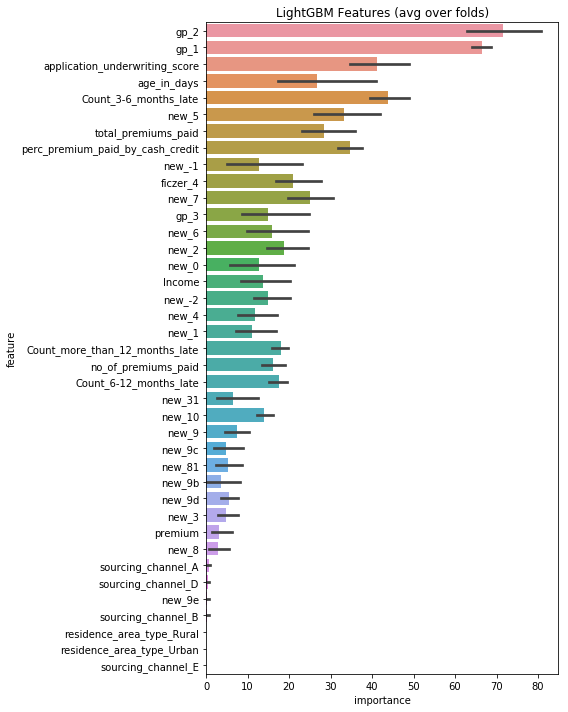

In [671]:
subm = sub_preds.to_frame()
subm.to_csv('output/5_splits_subm_lgbm_auc{:.8f}.csv'.format(score), index=True, float_format='%.8f')
Paramsy = pd.DataFrame(params_LGBM, index=params_LGBM)
Paramsy.to_csv('output/5_splits_parametry_score'+str(score)+'.csv', index=False)

# Plot feature importances
cols = pd.concat([f['importance'].rename('importance_{0}'.format(no)) for no, f in enumerate(feature_importance_dfs, 1)], axis=1).mean(axis=1).sort_values(ascending=False)[:50].index
best_features = pd.concat(feature_importance_dfs, axis=0).loc[cols]
plt.figure(figsize=(8,10))
best_features = best_features.reset_index()

cols2 = pd.concat([f['importance'].rename('importance_{0}'.format(no)) for no, f in enumerate(feature_importance_dfs, 1)], axis=1).mean(axis=1).sort_values(ascending=False).index
best_features_all = pd.concat(feature_importance_dfs, axis=0).loc[cols2]
best_features_all = best_features_all.reset_index()
best_features_all.to_csv('output/5_splits_feature_all'+str(score)+'.csv', index=False)
best_features.to_csv('output/5_splits_best_features_AUC'+str(score)+'.csv',index=False)

oof_preds.to_csv('output/OOF_5_splits_OOF_preds{:.8f}.csv'.format(score), index=True, float_format='%.8f')

sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('output/graphs_5_splits_lgbm_importances_top50'+str(score)+'.png')
plt.show()

In [169]:
data

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,new_1,new_2,new_3,new_4,new_5,new_6,new_7,new_8,new_9,new_10,new_-2,new_-1,new_0,ficzer_1,ficzer_2,ficzer_3,ficzer_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,0,0,3300,29313.333333,33.013005,0.000000,42900,0.0,0.0,0.0,0.000000,0.000000,1415.7,29863.333333,896.262958,0.747180,NaN,NaN,NaN,NaN
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,1,0,18000,24762.500000,58.989733,0.000000,378000,0.0,0.0,0.0,0.000000,26262.500000,180.0,27762.500000,445.204591,0.121586,NaN,NaN,NaN,NaN
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,0,1,3300,6736.666667,47.997262,6736.666667,23100,6600.0,9900.0,3300.0,7011.666667,0.000000,3026.1,7286.666667,146.084721,0.177062,NaN,NaN,NaN,NaN
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,1,0,9600,20075.833333,42.001369,0.000000,86400,0.0,0.0,0.0,0.000000,20875.833333,470.4,21675.833333,497.027451,0.181214,NaN,NaN,NaN,NaN
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,2,0,9600,15756.666667,85.968515,0.000000,115200,0.0,0.0,0.0,0.000000,33113.333333,499.2,17356.666667,192.589889,0.143721,NaN,NaN,NaN,NaN
59951,0.540,17527,282080,2.0,0.0,0.0,99.18,9,2,1,22200,21656.666667,47.986311,21656.666667,199800,44400.0,0.0,0.0,23506.666667,47013.333333,11988.0,25356.666667,489.861927,0.088238,NaN,NaN,NaN,NaN
54031,1.000,24829,118400,0.0,0.0,0.0,99.05,11,2,0,7500,9241.666667,67.978097,0.000000,82500,0.0,0.0,0.0,0.000000,19733.333333,7500.0,10491.666667,145.144790,0.109630,NaN,NaN,NaN,NaN
94290,1.000,21911,180240,1.0,6.0,4.0,99.33,3,1,0,9600,14220.000000,59.989049,0.000000,28800,9600.0,57600.0,38400.0,0.000000,15020.000000,9600.0,15820.000000,250.379033,0.130382,NaN,NaN,NaN,NaN
93730,0.621,9868,92520,0.0,0.0,0.0,99.58,4,1,0,7500,7085.000000,27.017112,0.000000,30000,0.0,0.0,0.0,0.000000,7710.000000,4657.5,8335.000000,285.374696,0.085667,NaN,NaN,NaN,NaN


### xgb method

In [277]:
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import gc

In [673]:
print("my 3rd OOF...!!")
SEED = 7    # CR7 always..
subm = pd.read_csv("input/sample_submission.csv")
print("Loading data...\n")
lb=LabelEncoder()
def LabelEncoding_Cat(df):
    df=df.copy()
    Cat_Var=df.select_dtypes('object').columns.tolist()
    for col in Cat_Var:
        df[col]=lb.fit_transform(df[col].astype('str'))
    return df    

def Fill_NA(df):
    df=df.copy()
    Num_Features=df.select_dtypes(['float64','int64']).columns.tolist()
    df[Num_Features]= df[Num_Features].fillna(-0)
    return df

# tr = p

my 3rd OOF...!!
Loading data...



In [687]:
# d.read_csv("input/train.csv") 
# te =pd.read_csv("input/test.csv")

tr = data
te = test
y=y

# categorical_feats = [f for f in tr.columns if tr[f].dtype == 'object']
# for f_ in categorical_feats:
#     tr[f_], indexer = pd.factorize(tr[f_])
#     te[f_] = indexer.get_indexer(te[f_])

tri=tr.shape[0]
# y = tr.renewal.copy()

tr_te=(tr.append(te))
#          .pipe(Fill_NA))

# gc.collect()
tr.shape[0]

79853

In [688]:
print("Preparing data...\n")
# tr_te.drop(labels=['id'],axis=1,inplace=True)
tr=tr_te.iloc[:tri,:].copy()
te=tr_te.iloc[tri:,:].copy()
data_train = tr
data_test = te



Preparing data...



In [689]:

data_train.fillna(-1, inplace=True)
data_test.fillna(-1, inplace=True)
cols = tr.columns

ntrain = data_train.shape[0]
ntest = data_test.shape[0]

print(data_train.shape)

(79853, 42)


In [678]:
data_train

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,0,0,3300
1,0.010,21546,315150,0.0,0.0,0.0,99.89,21,1,0,18000
2,0.917,17531,84140,2.0,3.0,1.0,98.69,7,0,1,3300
3,0.049,15341,250510,0.0,0.0,0.0,99.57,9,1,0,9600
4,0.052,31400,198680,0.0,0.0,0.0,99.87,12,2,0,9600
5,0.540,17527,282080,2.0,0.0,0.0,99.18,9,2,1,22200
6,1.000,24829,118400,0.0,0.0,0.0,99.05,11,2,0,7500
7,1.000,21911,180240,1.0,6.0,4.0,99.33,3,1,0,9600
8,0.621,9868,92520,0.0,0.0,0.0,99.58,4,1,0,7500
9,0.908,23008,107180,2.0,0.0,0.0,98.91,11,1,1,5400


In [691]:
kf = KFold(data_train.shape[0], n_folds=5, shuffle=True, random_state=7)
NFOLDS = 5
x_train = np.array(data_train)
x_test = np.array(data_test)
y_train = y.ravel()

# from https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867/code
class SklearnWrapper(object):
    def __init__(self, clf, seed=7, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        print("Training..")
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        print("Predicting..")
        return self.clf.predict_proba(x)


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        print("Training..")
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        print("Predicting..")
        return self.gbdt.predict(xgb.DMatrix(x))


def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)[:,1]  # or [:,0]
        oof_test_skf[i, :] = clf.predict(x_test)[:,1]  # or [:,0]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def get_oof_xgb(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)  # or [:,0]
        oof_test_skf[i, :] = clf.predict(x_test)  # or [:,0]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
    
et_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'auc',
    'nrounds': 350
}

cb_params = {
'iterations':1500,
'learning_rate':0.1,
'depth':6,
'l2_leaf_reg':40,
'bootstrap_type':'Bernoulli',
'subsample':0.7,
# 'scale_pos_weight':5,
'eval_metric':'AUC',
'metric_period':50,
'od_type':'Iter',
'od_wait':45,
'allow_writing_files':False    
}

xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = SklearnWrapper(clf=CatBoostClassifier, seed=SEED, params=cb_params)

print("xg..")
xg_oof_train, xg_oof_test = get_oof_xgb(xg)
# print("et..")
# et_oof_train, et_oof_test = get_oof(et)
# print("rf..")
# rf_oof_train, rf_oof_test = get_oof(rf)


xg..
Training..
Predicting..
Predicting..
Training..
Predicting..
Predicting..
Training..
Predicting..
Predicting..
Training..
Predicting..
Predicting..
Training..
Predicting..
Predicting..
rf..
Training..


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [692]:
print("cb..")
cb_oof_train, cb_oof_test = get_oof(cb)

x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

np.save('x_train', x_train)
np.save('x_test', x_test)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.85,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 15,
    'eval_metric': 'auc',
}

print("xgb cv..")
res = xgb.cv(xgb_params, dtrain, num_boost_round=2500, nfold=5, seed=42, stratified=True,
             early_stopping_rounds=50, verbose_eval=10, show_stdv=True)
best_nrounds = res.shape[0] - 1





cb..
Training..
0:	learn: 0.8210889	total: 17.2ms	remaining: 25.8s
50:	learn: 0.8440922	total: 1.04s	remaining: 29.5s
100:	learn: 0.8485901	total: 2.08s	remaining: 28.8s
150:	learn: 0.8520397	total: 3.14s	remaining: 28.1s
200:	learn: 0.8548524	total: 4.21s	remaining: 27.2s
250:	learn: 0.8578830	total: 5.28s	remaining: 26.2s
300:	learn: 0.8611308	total: 6.34s	remaining: 25.3s
350:	learn: 0.8638860	total: 7.41s	remaining: 24.3s
400:	learn: 0.8663843	total: 8.48s	remaining: 23.3s
450:	learn: 0.8690630	total: 9.55s	remaining: 22.2s
500:	learn: 0.8715044	total: 10.6s	remaining: 21.2s
550:	learn: 0.8740037	total: 11.7s	remaining: 20.1s
600:	learn: 0.8764453	total: 12.8s	remaining: 19.1s
650:	learn: 0.8789050	total: 13.8s	remaining: 18s
700:	learn: 0.8814842	total: 14.9s	remaining: 17s
750:	learn: 0.8841373	total: 15.9s	remaining: 15.9s
800:	learn: 0.8863299	total: 17s	remaining: 14.8s
850:	learn: 0.8888532	total: 18s	remaining: 13.7s
900:	learn: 0.8912375	total: 19.1s	remaining: 12.7s
950:	l

[40]	train-auc:0.845127+0.00184722	test-auc:0.841392+0.00779827
[50]	train-auc:0.845259+0.00187302	test-auc:0.841521+0.00767576
[60]	train-auc:0.845431+0.0018268	test-auc:0.841617+0.00765534
[70]	train-auc:0.845585+0.00183614	test-auc:0.841692+0.00772162
[80]	train-auc:0.845732+0.00184558	test-auc:0.841654+0.0077122
[90]	train-auc:0.845895+0.00184221	test-auc:0.841681+0.00771309
[100]	train-auc:0.846082+0.00190269	test-auc:0.841748+0.00758557
[110]	train-auc:0.846229+0.00193197	test-auc:0.841768+0.0075593
[120]	train-auc:0.846367+0.00192932	test-auc:0.84177+0.00755899
[130]	train-auc:0.846515+0.00190794	test-auc:0.841807+0.00758098
[140]	train-auc:0.846653+0.00190977	test-auc:0.841768+0.00755033
[150]	train-auc:0.846755+0.00189395	test-auc:0.841766+0.00755659
[160]	train-auc:0.846905+0.00186054	test-auc:0.841772+0.00752288
[170]	train-auc:0.847042+0.00186461	test-auc:0.841771+0.00751774
[180]	train-auc:0.847142+0.0018715	test-auc:0.841762+0.00752373


In [693]:
submit = pd.read_csv('input/sample_submission.csv')

In [694]:
print("meta xgb train..")
gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
fi = gbdt.predict(dtest)
fi = np.array(fi)
np.save('fi', fi)

submit['renewal'] = fi

meta xgb train..


In [695]:
submit.to_csv('xgb_submision_4.csv',index=False)

In [696]:
submit

,id,renewal,incentives
0,649,0.857308,1650
1,81136,0.855078,1650
2,70762,0.727489,1650
3,53935,0.849714,1650
4,15476,0.838489,1650
5,64797,0.858799,1650
6,67412,0.744011,1650
7,44241,0.726195,1650
8,5069,0.860589,1650
9,16615,0.860946,1650


In [703]:
roc_auc_score(y1,xg_oof_train), roc_auc_score(y, oof_preds)

(0.8166029914737922, 0.8436106096970883)

In [701]:
y1 = y.reset_index()

In [702]:
y1.columns = ['id', 'ta']
y1 = y1['ta']
y1

0        1
1        1
2        0
3        1
4        1
5        1
6        1
7        0
8        1
9        0
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       0
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
79823    0
79824    1
79825    1
79826    1
79827    1
79828    1
79829    0
79830    1
79831    1
79832    1
79833    1
79834    1
79835    1
79836    1
79837    1
79838    1
79839    1
79840    1
79841    1
79842    1
79843    1
79844    1
79845    1
79846    1
79847    1
79848    1
79849    1
79850    1
79851    1
79852    0
Name: ta, Length: 79853, dtype: int64

In [698]:
xg_oof_train = pd.DataFrame(xg_oof_train)

In [699]:
xg_oof_train.columns = ['ta']
xg_oof_train = xg_oof_train['ta']
xg_oof_train

0        0.940723
1        0.992743
2        0.495043
3        0.995455
4        0.995980
5        0.813066
6        0.995725
7        0.448758
8        0.943704
9        0.835787
10       0.970636
11       0.958993
12       0.875370
13       0.992412
14       0.975723
15       0.747601
16       0.993813
17       0.986323
18       0.990587
19       0.313631
20       0.910937
21       0.977339
22       0.981583
23       0.641480
24       0.856648
25       0.998762
26       1.009286
27       0.992128
28       0.996559
29       0.996082
           ...   
79823    0.689898
79824    0.930817
79825    0.984468
79826    1.000160
79827    1.006302
79828    0.946536
79829    0.868184
79830    0.952002
79831    0.955594
79832    0.915600
79833    0.988059
79834    0.979746
79835    1.000455
79836    1.005127
79837    0.981466
79838    0.990300
79839    0.642292
79840    1.009767
79841    1.004672
79842    0.985106
79843    0.985218
79844    0.899391
79845    0.668764
79846    0.988218
79847    0